Group 20 members:
- Janick Michot:          michojan@students.zhaw.ch
- Andre von Aarburg :     andre.vonaarburg@ost.ch
- Manuel Weiss:           weissman@students.zhaw.ch

# Exercise 2 | Word polarity detection with word embedding

The objective is to build a system that takes as input a word and outputs a probability that the
word has a positive or negative connotation (polarity). As illustrated in Figure 2, the system is
composed of two parts in which the word embedding part will leverage on pre-trained vectors
such as the one obtained with word2vec or GloVe. If you are not familiar with word embeddings,
we recommend you to watch the class material including videos and pdf posted on Moodle.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, models, layers, callbacks, optimizers
import matplotlib.pyplot as plt
import pandas as pd

## a) Read lexicons

Download lists of positive and negative words from the Opinion Lexicon
available from https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html. A zip
is also provided on Moodle. Listing 1 provides an example of function to read the lexicons.
You may want to complete the code to remove lines that start with ;, that end with +
and to remove empty lines. You should get 2005 positive words and 4783 negative words.

In [87]:
def read_vocabulary(filename: str) -> list[str]:
    with open(filename, 'r', encoding='ISO-8859-1') as f:
        content: list[str] = f.readlines() # content is a list of lines
        content = [x.strip() for x in content] # removing newline chars
        content = [x for x in content if not x.startswith(";") and not x.endswith("+") and not x == '']
        return content

In [101]:
positive_filename: str = "./data/positive-words.txt"
negative_filename: str = "./data/negative-words.txt"

positive: np.ndarray = np.array(read_vocabulary(positive_filename))
negative: np.ndarray = np.array(read_vocabulary(negative_filename))

print("# positives:", len(positive), "\n")
print("positive examples: \n", positive[25:30], "\n")
print("# negatives:", len(negative), "\n")
print("negative examples: \n", negative[25:30], "\n")

# positives: 2005 

positive examples: 
 ['adaptive' 'adequate' 'adjustable' 'admirable' 'admirably'] 

# negatives: 4783 

negative examples: 
 ['abuses' 'abusive' 'abysmal' 'abysmally' 'abyss'] 



## b) Convert words into vectors
You can here go for two options : either by querying
an online API that returns you the vectors for a given word, or download a pre-trained
word-vector dictionary (word2vec, GloVe, etc.). The code provided in Listing 2 shows you
how to realise this using a GloVe embedding – zip also provided on Moodle.

### Glove
Importing pretrained glove embeddings

In [85]:
def load_glove_embeddings(path: str):
    embeddings = {}
    with open(path, 'r', encoding='utf−8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors
    return embeddings

In [20]:
glove_path: str = './data/glove.6B.50d.txt'
glove_dict = load_glove_embeddings(glove_path)

In [25]:
print("Type:", type(glove_dict), "\n")
print("Keys:")
print(list(glove_dict.keys())[:10])

Type: <class 'dict'> 

Keys:
['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]


In [80]:
word = 'happy'
glove_test_vector = glove_dict[word]

print(glove_test_vector, "\n")
print("Glove embedding size:", len(glove_test_vector))

[ 0.092086  0.2571   -0.58693  -0.37029   1.0828   -0.55466  -0.78142
  0.58696  -0.58714   0.46318  -0.11267   0.2606   -0.26928  -0.072466
  1.247     0.30571   0.56731   0.30509  -0.050312 -0.64443  -0.54513
  0.86429   0.20914   0.56334   1.1228   -1.0516   -0.78105   0.29656
  0.7261   -0.61392   2.4225    1.0142   -0.17753   0.4147   -0.12966
 -0.47064   0.3807    0.16309  -0.323    -0.77899  -0.42473  -0.30826
 -0.42242   0.055069  0.38267   0.037415 -0.4302   -0.39442   0.10511
  0.87286 ] 

Glove embedding size: 50


### c) Prepare the training and testing sets.
Prepare the tensors X_train for training
by taking the corresponding vectors of 1500 positive and 1500 negative words from the
lexicon. Prepare the Y_train target output tensor corresponding to the training set. You
can, for example use the target [1.0, 0.0] for a positive word and [0.0, 1.0] for a negative
word. For an embedding dimension of 50, the shapes of your X_train and Y_train tensors
should be (3000,50) and (3000,2). In a similar way, prepare X_test and Y_test tensors.

In [112]:
# filtering words not in glove dictionary

positive_words_not_in_glove = [word for word in positive if word not in glove_dict]
filtered_positive = np.array([word for word in positive if word not in positive_words_not_in_glove])

print("Positive words not in glove:", len(positive_words_not_in_glove))
print("Remaining length positive:", len(filtered_positive))

negative_words_not_in_glove = [word for word in negative if word not in glove_dict]
filtered_negative = np.array([word for word in negative if word not in negative_words_not_in_glove])

print("Negative words not in glove:", len(negative_words_not_in_glove))
print("Remaining length negative:", len(filtered_negative))


Positive words not in glove: 112
Remaining length positive: 1893
Negative words not in glove: 438
Remaining length negative: 4345


In [187]:
# Splitting up to positive / negative test and train sets

n_train_per_polarity = 1500
n_test_per_polarity = len(filtered_positive) - n_train_per_polarity

n_train = n_train_per_polarity * 2
n_test = n_test_per_polarity * 2

positive_indices = np.arange(len(filtered_positive))


train_positive_indices = np.random.choice(positive_indices, n_train_per_polarity, replace=False)
remaining_positive_indices = np.delete(positive_indices, train_positive_indices)

test_positive_indices = np.random.choice(remaining_positive_indices, n_test_per_polarity, replace=False)

train_positive_words = filtered_positive[train_positive_indices]
test_positive_words = filtered_positive[test_positive_indices]


negative_indices = np.arange(len(filtered_negative))
train_negative_indices = np.random.choice(negative_indices, n_train_per_polarity, replace=False)
remaining_negative_indices = np.delete(negative_indices, train_negative_indices)

test_negative_indices = np.random.choice(remaining_negative_indices, n_test_per_polarity, replace=False)

train_negative_words = filtered_negative[train_negative_indices]
test_negative_words = filtered_negative[test_negative_indices]

print("Train positive size:", len(train_positive_words))
print("Test positive size:", len(test_positive_words))
print("Train negative size:", len(train_negative_words))
print("Test negative size:", len(test_negative_words))

Train positive size: 1500
Test positive size: 393
Train negative size: 1500
Test negative size: 393


In [188]:
# transforming sets to tensors
positive_label = [1.0, 0.0]
negative_label = [0.0, 1.0]

train_positive = [[glove_dict[word], positive_label] for word in train_positive_words]
test_positive = [[glove_dict[word], positive_label] for word in test_positive_words]

train_negative = [[glove_dict[word], negative_label] for word in train_negative_words]
test_negative = [[glove_dict[word], negative_label] for word in test_negative_words]

print("Train positive size:", len(train_positive))
print("Test positive size:", len(test_positive))
print("Train negative size:", len(train_negative))
print("Test negative size:", len(test_negative))

Train positive size: 1500
Test positive size: 393
Train negative size: 1500
Test negative size: 393


In [189]:
train = np.concatenate((train_positive, train_negative), axis=0, dtype=object)
np.random.shuffle(train)

test = np.concatenate((test_positive, test_negative), axis=0, dtype=object)
np.random.shuffle(test)

In [190]:
X_train = np.stack(np.asarray(train[:, 0]), axis=0)
X_train = tf.convert_to_tensor(X_train, dtype='float32')

y_train = np.stack(np.asarray(train[:, 1]), axis=0)
y_train = tf.convert_to_tensor(y_train, dtype='float32')

X_test = np.stack(np.asarray(test[:, 0]), axis=0)
X_test = tf.convert_to_tensor(X_test, dtype='float32')

y_test = np.stack(np.asarray(test[:, 1]), axis=0)
y_test = tf.convert_to_tensor(y_test, dtype='float32')

print("X_train Shape", X_train.shape)
print("y_train Shape", y_train.shape)
print("X_test Shape", X_test.shape)
print("y_test Shape", y_test.shape)

X_train Shape (3000, 50)
y_train Shape (3000, 2)
X_test Shape (786, 50)
y_test Shape (786, 2)


## d) Train and evaluate a classifier
 Build a model, e.g. a double Dense layers in Keras
(MLP) and train it. Report on the evolution of the loss and accuracy along the epochs.
You should reach about 90% accuracy on the training set and 85% accuracy on the test
set. Report on your model structure and fitting strategy.

In [199]:
n_classes = len(positive_label)
input_shape = X_train.shape[1:]

batch_size: int =64
n_epochs: int = 10

optimizer: str = 'adam'
metrics: list[str] = ['accuracy']
loss: str = 'categorical_crossentropy'

In [204]:
model: Sequential = Sequential(name="Sentiment_Analysis_Classifier")

model.add(layers.Dense(units=200, input_shape=input_shape, activation='relu'))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dense(units=20, activation='relu'))
model.add(layers.Dense(units=n_classes, activation='softmax'))

In [205]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(model.summary())

Model: "Sentiment_Analysis_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 200)               10200     
                                                                 
 dense_7 (Dense)             (None, 100)               20100     
                                                                 
 dense_8 (Dense)             (None, 20)                2020      
                                                                 
 dense_9 (Dense)             (None, 2)                 42        
                                                                 
Total params: 32,362
Trainable params: 32,362
Non-trainable params: 0
_________________________________________________________________
None


In [206]:
log: callbacks.History = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
47/47 [==============================] - 0s 4ms/step - loss: 0.4293 - accuracy: 0.8063 - val_loss: 0.3156 - val_accuracy: 0.8651
Epoch 2/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2985 - accuracy: 0.8750 - val_loss: 0.2989 - val_accuracy: 0.8753
Epoch 3/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2669 - accuracy: 0.8867 - val_loss: 0.3029 - val_accuracy: 0.8702
Epoch 4/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2393 - accuracy: 0.8980 - val_loss: 0.3099 - val_accuracy: 0.8715
Epoch 5/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2082 - accuracy: 0.9157 - val_loss: 0.3286 - val_accuracy: 0.8626
Epoch 6/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1878 - accuracy: 0.9263 - val_loss: 0.3078 - val_accuracy: 0.8868
Epoch 7/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1535 - accuracy: 0.9423 - val_loss: 0.3212 - val_accuracy: 0.8779
Epoch 8/10
47/47 [==

## e) Analysis of results and discussions
Report on your experiments and comment your
classification performances. Find 5 to 10 words which are not in your training set and on
which the system thinks it is clearly positive or negative. Find some words on which the
system hesitates, i.e. with output probabilities in range [0.4-0.6]). Are these words and
outputs making sense to you ?

In [207]:
def plot_metrics(
        model: Sequential,
        logs: callbacks.History,
        ax: plt.Axes = None,
        color: str = None,
        display_train_accuracy: bool = True,
        display_train_loss: bool = False,
        display_val_accuracy: bool = True,
        display_val_loss: bool = False
) -> None:
    single_plot: bool = ax is None
    fig = None

    if single_plot:
        fig = plt.figure(figsize=(12, 7))
        ax = fig.add_subplot(1,1,1)

    if display_train_accuracy:
        ax.plot(logs.history['accuracy'], linestyle="--", label=f"Acc_Train_{model.name}", color=color)

    if display_train_loss:
        ax.plot(logs.history['loss'], linestyle="--", label=f"Loss_Train_{model.name}", color=color)

    if display_val_accuracy:
        ax.plot(logs.history['val_accuracy'], linestyle="-", label=f"Acc_Val_{model.name}", color=color)

    if display_val_loss:
        ax.plot(logs.history['val_loss'], linestyle="-", label=f"Loss_Val_{model.name}", color=color)

    if not display_val_loss and not display_train_loss:
        ax.set_ylim(0, 1)

    if single_plot:
        fig.suptitle("Metrics Plot")
        ax.set_xlabel("# Epochs")
        ax.set_ylabel("Accuracy / Loss")
        plt.legend()
        plt.show()

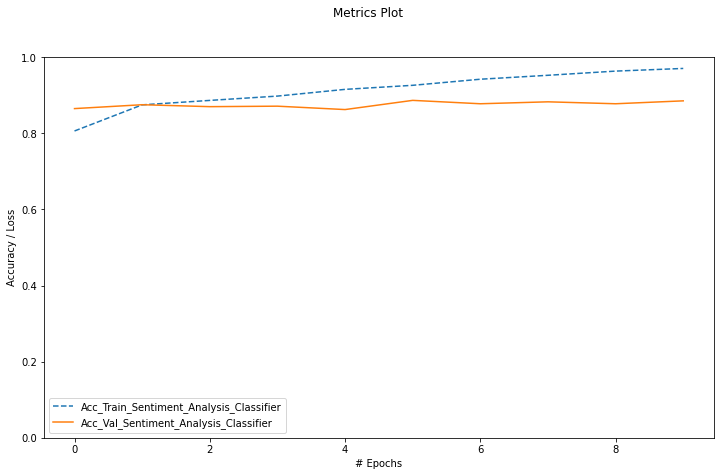

Training accuracy: 0.9707
Test accuracy: 0.8855


In [218]:
plot_metrics(model, logs=log)

print("Training accuracy:", np.round(log.history['accuracy'][len(log.history['accuracy']) - 1], 4))
print("Test accuracy:", np.round(log.history['val_accuracy'][len(log.history['val_accuracy']) - 1], 4))

### Performance report
As we can see the model achieved the expected results (85%) of the exercise with an accuarcy on the test set of 88,6%.
With such a fast training and such a simple MLP we think this is a rather good result for an NLP task. We will also try increase the accuracy even further but we also experienced the tendency to overfit even with such a small number of epochs.

In [265]:
def polarity_to_label(polarity: int):
    return "Positive" if polarity == 0 else "Negative"

In [282]:
def test_word(word: str, polarity: int, verbose: bool = True):
    assert word in glove_dict, "Word is not in used glove dict"
    embeddings = tf.convert_to_tensor([tf.convert_to_tensor(glove_dict[word])])
    pred = model.predict(embeddings)
    pred_polarity = tf.argmax(pred, axis=1)[0]
    correct = pred_polarity == polarity

    if verbose:
        display(pd.DataFrame([[word, tf.get_static_value(correct), polarity_to_label(tf.get_static_value(pred_polarity)), polarity_to_label(polarity), pred]], columns=["Word", "Correct", "Predicted", "Ground Truth", "Prediction"]))

    return pred_polarity == polarity

In [288]:
word_list = [('pioneering', 0), ('easy-going', 0), ('cuddly', 0), ('shorthanded', 1), ('extratropical', 0), ('the', 0), ('doctored', 1), ('subsidised', 0), ('globular', 0)]

for word in word_list:
    test_word(word[0], word[1])
    print()

,Word,Correct,Predicted,Ground Truth,Prediction
0,pioneering,True,Positive,Positive,"[[0.9999944, 5.6017584e-06]]"


,Word,Correct,Predicted,Ground Truth,Prediction
0,easy-going,True,Positive,Positive,"[[0.991557, 0.008442951]]"


,Word,Correct,Predicted,Ground Truth,Prediction
0,cuddly,True,Positive,Positive,"[[0.8580523, 0.14194766]]"


,Word,Correct,Predicted,Ground Truth,Prediction
0,shorthanded,True,Negative,Negative,"[[0.05888296, 0.94111705]]"


,Word,Correct,Predicted,Ground Truth,Prediction
0,extratropical,False,Negative,Positive,"[[2.397083e-06, 0.9999976]]"


,Word,Correct,Predicted,Ground Truth,Prediction
0,the,True,Positive,Positive,"[[0.98785365, 0.012146415]]"


,Word,Correct,Predicted,Ground Truth,Prediction
0,doctored,True,Negative,Negative,"[[0.06577277, 0.93422717]]"


,Word,Correct,Predicted,Ground Truth,Prediction
0,subsidised,True,Positive,Positive,"[[0.84743017, 0.15256985]]"


,Word,Correct,Predicted,Ground Truth,Prediction
0,globular,False,Negative,Positive,"[[0.19091307, 0.809087]]"


### Result interpretation
As the results show the system is always quite confident about what to predict. This is possibly highly due to the use of the softmax function.
Even if humans can not assign a clear label to a word if it's positive or negative, the model predicts quite confident a polarity.

Examples:
globular -> no polarity -> system predicts with 80% to be negative
the -> no polarity -> system predicts with 98% to be positive
extratropical -> no polarity -> stystem predicts with 99% to be negative


In our test to all other words where humans (we) were able to assign a polarity it could clearly find the correct polarity even if all the words were not included in the training set which is quite impressive.

### f) Optional – Extension to sentences.
Could you use the above system to make a polarity
detection for the comments given by clients on products, e.g. on www.digitech.ch ? What
would be the limitations of such system and how could we improve it ? What is happening
when a word is not in the dictionary of the embedding ?

#### Answer
As system as we used above which is able to predict the sentiment of words could be used in that way for sentences, that we predict the polarity of each word in the comment and conduct eventually a majority vote over all polarities predicted.

Limitations:
If the system predicts a clear polarity to each word even if they haven't the result of the vote could be compromised.
A possible solution is to preprocess the comments in order to remove stopwords.
With a POS tagging we could also focus on adjectives rather than nouns etc.

A second limitation could be that the words doesn't exists in our word embeddings model. We may can use an api to find synonyms of the words which exists. Otherwise this may are words specific to the product, which probalby eitherway haven't a polarity. But this is only an assumption. But with this we could filter out this words. Or extending the model with the comments we already have.